# Hand Landmark Detector Tutorial
# Deploying the Hand Landmark Detector with Vitis-AI for DPU inference

## Goal

In this notebook we show how to deploy the BlazeHandLandmark model (a PyTorch version of the mediapipe hand-gesture)
with Vitis-AI for deployment on the DPU. We will cover:

* Create the PyTorch model and load pre-trained weights
* Quantizing and evaluating the PyTorch model
* Compiling for DPU using the Vitis AI compiler


## References

* [BlazeFace-PyTorch](https://github.com/hollance/BlazeFace-PyTorch)
* [MediaPipePytorch](https://github.com/zmurez/MediaPipePyTorch)
* [Vitis AI v3.5](https://github.com/Xilinx/Vitis-AI/tree/v3.5)
   * [vai_q_pytorch](https://docs.xilinx.com/r/en-US/ug1414-vitis-ai/Running-vai_q_pytorch)
   * [vai_c_xir](https://docs.xilinx.com/r/en-US/ug1414-vitis-ai/Compiling-for-DPU)


## Version History
* Jan 10, 2024
    * Preliminary revision

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

print("OpenCV version : ",cv2.__version__)
print("PyTorch version : ",torch.__version__)

OpenCV version :  4.7.0
PyTorch version :  1.13.1


In [2]:
# use GPU if available   
if (torch.cuda.device_count() > 0):
  print('You have',torch.cuda.device_count(),'CUDA devices available')
  for i in range(torch.cuda.device_count()):
    print(' Device',str(i),': ',torch.cuda.get_device_name(i))
  print('Selecting device 0..')
  device = torch.device('cuda:0')
else:
  print('No CUDA devices available..selecting CPU')
  device = torch.device('cpu')



No CUDA devices available..selecting CPU


# 1. Model Definition

Following sections copied from the MediaPipePyTorch repository

# Visualization

../MediaPipePytorch/visualization.py

In [3]:
def draw_detections(img, detections, with_keypoints=True):
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    n_keypoints = detections.shape[1] // 2 - 2

    for i in range(detections.shape[0]):
        ymin = detections[i, 0]
        xmin = detections[i, 1]
        ymax = detections[i, 2]
        xmax = detections[i, 3]
        
        start_point = (int(xmin), int(ymin))
        end_point = (int(xmax), int(ymax))
        img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), 1) 

        if with_keypoints:
            for k in range(n_keypoints):
                kp_x = int(detections[i, 4 + k*2    ])
                kp_y = int(detections[i, 4 + k*2 + 1])
                cv2.circle(img, (kp_x, kp_y), 2, (0, 0, 255), thickness=2)
    return img


def draw_roi(img, roi):
    for i in range(roi.shape[0]):
        (x1,x2,x3,x4), (y1,y2,y3,y4) = roi[i]
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,0), 2)
        cv2.line(img, (int(x1), int(y1)), (int(x3), int(y3)), (0,255,0), 2)
        cv2.line(img, (int(x2), int(y2)), (int(x4), int(y4)), (0,0,0), 2)
        cv2.line(img, (int(x3), int(y3)), (int(x4), int(y4)), (0,0,0), 2)


def draw_landmarks(img, points, connections=[], color=(0, 255, 0), size=2):
    points = points[:,:2]
    for point in points:
        x, y = point
        x, y = int(x), int(y)
        cv2.circle(img, (x, y), size, color, thickness=size)
    for connection in connections:
        x0, y0 = points[connection[0]]
        x1, y1 = points[connection[1]]
        x0, y0 = int(x0), int(y0)
        x1, y1 = int(x1), int(y1)
        cv2.line(img, (x0, y0), (x1, y1), (0,0,0), size)



# https://github.com/metalwhale/hand_tracking/blob/b2a650d61b4ab917a2367a05b85765b81c0564f2/run.py
#        8   12  16  20
#        |   |   |   |
#        7   11  15  19
#    4   |   |   |   |
#    |   6   10  14  18
#    3   |   |   |   |
#    |   5---9---13--17
#    2    \         /
#     \    \       /
#      1    \     /
#       \    \   /
#        ------0-
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (5, 6), (6, 7), (7, 8),
    (9, 10), (10, 11), (11, 12),
    (13, 14), (14, 15), (15, 16),
    (17, 18), (18, 19), (19, 20),
    (0, 5), (5, 9), (9, 13), (13, 17), (0, 17)
]

POSE_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,7),
    (0,4), (4,5), (5,6), (6,8),
    (9,10),
    (11,13), (13,15), (15,17), (17,19), (19,15), (15,21),
    (12,14), (14,16), (16,18), (18,20), (20,16), (16,22),
    (11,12), (12,24), (24,23), (23,11)
]

# Vertex indices can be found in
# github.com/google/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualisation.png
# Found in github.com/google/mediapipe/python/solutions/face_mesh.py
FACE_CONNECTIONS = [
    # Lips.
    (61, 146), (146, 91), (91, 181), (181, 84), (84, 17),
    (17, 314), (314, 405), (405, 321), (321, 375), (375, 291),
    (61, 185), (185, 40), (40, 39), (39, 37), (37, 0),
    (0, 267), (267, 269), (269, 270), (270, 409), (409, 291),
    (78, 95), (95, 88), (88, 178), (178, 87), (87, 14),
    (14, 317), (317, 402), (402, 318), (318, 324), (324, 308),
    (78, 191), (191, 80), (80, 81), (81, 82), (82, 13),
    (13, 312), (312, 311), (311, 310), (310, 415), (415, 308),
    # Left eye.
    (263, 249), (249, 390), (390, 373), (373, 374), (374, 380),
    (380, 381), (381, 382), (382, 362), (263, 466), (466, 388),
    (388, 387), (387, 386), (386, 385), (385, 384), (384, 398),
    (398, 362),
    # Left eyebrow.
    (276, 283), (283, 282), (282, 295), (295, 285), (300, 293),
    (293, 334), (334, 296), (296, 336),
    # Right eye.
    (33, 7), (7, 163), (163, 144), (144, 145), (145, 153),
    (153, 154), (154, 155), (155, 133), (33, 246), (246, 161),
    (161, 160), (160, 159), (159, 158), (158, 157), (157, 173),
    (173, 133),
    # Right eyebrow.
    (46, 53), (53, 52), (52, 65), (65, 55), (70, 63), (63, 105),
    (105, 66), (66, 107),
    # Face oval.
    (10, 338), (338, 297), (297, 332), (332, 284), (284, 251),
    (251, 389), (389, 356), (356, 454), (454, 323), (323, 361),
    (361, 288), (288, 397), (397, 365), (365, 379), (379, 378),
    (378, 400), (400, 377), (377, 152), (152, 148), (148, 176),
    (176, 149), (149, 150), (150, 136), (136, 172), (172, 58),
    (58, 132), (132, 93), (93, 234), (234, 127), (127, 162),
    (162, 21), (21, 54), (54, 103), (103, 67), (67, 109),
    (109, 10)
]

## Blaze Base
../MediaPipePytorch/blazebase.py

In [4]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def resize_pad(img):
    """ resize and pad images to be input to the detectors

    The face and palm detector networks take 256x256 and 128x128 images
    as input. As such the input image is padded and resized to fit the
    size while maintaing the aspect ratio.

    Returns:
        img1: 256x256
        img2: 128x128
        scale: scale factor between original image and 256x256 image
        pad: pixels of padding in the original image
    """

    size0 = img.shape
    if size0[0]>=size0[1]:
        h1 = 256
        w1 = 256 * size0[1] // size0[0]
        padh = 0
        padw = 256 - w1
        scale = size0[1] / w1
    else:
        h1 = 256 * size0[0] // size0[1]
        w1 = 256
        padh = 256 - h1
        padw = 0
        scale = size0[0] / h1
    padh1 = padh//2
    padh2 = padh//2 + padh%2
    padw1 = padw//2
    padw2 = padw//2 + padw%2
    img1 = cv2.resize(img, (w1,h1))
    img1 = np.pad(img1, ((padh1, padh2), (padw1, padw2), (0,0)))
    pad = (int(padh1 * scale), int(padw1 * scale))
    img2 = cv2.resize(img1, (128,128))
    return img1, img2, scale, pad


def denormalize_detections(detections, scale, pad):
    """ maps detection coordinates from [0,1] to image coordinates

    The face and palm detector networks take 256x256 and 128x128 images
    as input. As such the input image is padded and resized to fit the
    size while maintaing the aspect ratio. This function maps the
    normalized coordinates back to the original image coordinates.

    Inputs:
        detections: nxm tensor. n is the number of detections.
            m is 4+2*k where the first 4 valuse are the bounding
            box coordinates and k is the number of additional
            keypoints output by the detector.
        scale: scalar that was used to resize the image
        pad: padding in the x and y dimensions

    """
    detections[:, 0] = detections[:, 0] * scale * 256 - pad[0]
    detections[:, 1] = detections[:, 1] * scale * 256 - pad[1]
    detections[:, 2] = detections[:, 2] * scale * 256 - pad[0]
    detections[:, 3] = detections[:, 3] * scale * 256 - pad[1]

    detections[:, 4::2] = detections[:, 4::2] * scale * 256 - pad[1]
    detections[:, 5::2] = detections[:, 5::2] * scale * 256 - pad[0]
    return detections




class BlazeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act='relu', skip_proj=False):
        super(BlazeBlock, self).__init__()

        self.stride = stride
        self.kernel_size = kernel_size
        self.channel_pad = out_channels - in_channels

        # TFLite uses slightly different padding than PyTorch 
        # on the depthwise conv layer when the stride is 2.
        if stride == 2:
            self.max_pool = nn.MaxPool2d(kernel_size=stride, stride=stride)
            padding = 0
        else:
            padding = (kernel_size - 1) // 2

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding, 
                      groups=in_channels, bias=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=1, stride=1, padding=0, bias=True),
        )

        if skip_proj:
            self.skip_proj = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=1, stride=1, padding=0, bias=True)
        else:
            self.skip_proj = None

        if act == 'relu':
            self.act = nn.ReLU(inplace=True)
        elif act == 'prelu':
            self.act = nn.PReLU(out_channels)
        else:
            raise NotImplementedError("unknown activation %s"%act)

    def forward(self, x):
        if self.stride == 2:
            if self.kernel_size==3:
                h = F.pad(x, (0, 2, 0, 2), "constant", 0)
            else:
                h = F.pad(x, (1, 2, 1, 2), "constant", 0)
            x = self.max_pool(x)
        else:
            h = x

        if self.skip_proj is not None:
            x = self.skip_proj(x)
        elif self.channel_pad > 0:
            print("[BlazeBlock] BEFORE F.pad : x.shape=",x.shape," channel_pad=",self.channel_pad)
            x = F.pad(x, (0, 0, 0, 0, 0, self.channel_pad), "constant", 0)
            print("[BlazeBlock] AFTER  F.pad : x.shape=",x.shape)

        return self.act(self.convs(h) + x)


class FinalBlazeBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(FinalBlazeBlock, self).__init__()

        # TFLite uses slightly different padding than PyTorch
        # on the depthwise conv layer when the stride is 2.
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels,
                      kernel_size=kernel_size, stride=2, padding=0,
                      groups=channels, bias=True),
            nn.Conv2d(in_channels=channels, out_channels=channels,
                      kernel_size=1, stride=1, padding=0, bias=True),
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        h = F.pad(x, (0, 2, 0, 2), "constant", 0)

        return self.act(self.convs(h))


class BlazeBase(nn.Module):
    """ Base class for media pipe models. """

    def _device(self):
        """Which device (CPU or GPU) is being used by this model?"""
        return self.classifier_8.weight.device
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()        


class BlazeLandmark(BlazeBase):
    """ Base class for landmark models. """

    def extract_roi(self, frame, xc, yc, theta, scale):
        
        print("[extract_roi] frame.shape=",frame.shape)
        print("[extract_roi] xc.shape=",xc.shape," xc=",xc)
        print("[extract_roi] yc.shape=",yc.shape," yc=",yc)
        print("[extract_roi] theta.shape=",theta.shape," theta=",theta)
        print("[extract_roi] scale.shape=",scale.shape," scale=",scale)

        # take points on unit square and transform them according to the roi
        points = torch.tensor([[-1, -1, 1, 1],
                            [-1, 1, -1, 1]], device=scale.device).view(1,2,4)
        #print("[extract_roi] points.shape=",points.shape)
        #print("[extract_roi] points=",points)
        points = points * scale.view(-1,1,1)/2
        #print("[extract_roi] points=",points)
        theta = theta.view(-1, 1, 1)
        #print("[extract_roi] theta.shape=",theta.shape)
        R = torch.cat((
            torch.cat((torch.cos(theta), -torch.sin(theta)), 2),
            torch.cat((torch.sin(theta), torch.cos(theta)), 2),
            ), 1)
        print("[extract_roi] R.shape=",R.shape," R=",R)
        center = torch.cat((xc.view(-1,1,1), yc.view(-1,1,1)), 1)
        print("[extract_roi] center.shape=",center.shape," center=",center)
        points = R @ points + center
        print("[extract_roi] points.shape=",points.shape)

        # use the points to compute the affine transform that maps 
        # these points back to the output square
        res = self.resolution
        points1 = np.array([[0, 0, res-1],
                            [0, res-1, 0]], dtype=np.float32).T
        affines = []
        imgs = []
        for i in range(points.shape[0]):
            pts = points[i, :, :3].cpu().numpy().T
            #print("[extract_roi] points.shape=",points.shape," point=",points)
            #print("[extract_roi] pts.shape=",pts.shape," pts=",pts)
            #print("[extract_roi] points1.shape=",points1.shape," points1=",points1)
            M = cv2.getAffineTransform(pts, points1)
            img = cv2.warpAffine(frame, M, (res,res))#, borderValue=127.5)
            img = torch.tensor(img, device=scale.device)
            imgs.append(img)
            affine = cv2.invertAffineTransform(M).astype('float32')
            affine = torch.tensor(affine, device=scale.device)
            affines.append(affine)
        if imgs:
            imgs = torch.stack(imgs).permute(0,3,1,2).float() / 255.#/ 127.5 - 1.0
            affines = torch.stack(affines)
        else:
            imgs = torch.zeros((0, 3, res, res), device=scale.device)
            affines = torch.zeros((0, 2, 3), device=scale.device)

        return imgs, affines, points

    def denormalize_landmarks(self, landmarks, affines):
        landmarks[:,:,:2] *= self.resolution
        for i in range(len(landmarks)):
            landmark, affine = landmarks[i], affines[i]
            landmark = (affine[:,:2] @ landmark[:,:2].T + affine[:,2:]).T
            landmarks[i,:,:2] = landmark
        return landmarks



class BlazeDetector(BlazeBase):
    """ Base class for detector models.

    Based on code from https://github.com/tkat0/PyTorch_BlazeFace/ and
    https://github.com/hollance/BlazeFace-PyTorch and
    https://github.com/google/mediapipe/
    """
    def load_anchors(self, path):
        self.anchors = torch.tensor(np.load(path), dtype=torch.float32, device=self._device())
        assert(self.anchors.ndimension() == 2)
        assert(self.anchors.shape[0] == self.num_anchors)
        assert(self.anchors.shape[1] == 4)

    def _preprocess(self, x):
        """Converts the image pixels to the range [-1, 1]."""
        return x.float() / 255.# 127.5 - 1.0

    def predict_on_image(self, img):
        """Makes a prediction on a single image.

        Arguments:
            img: a NumPy array of shape (H, W, 3) or a PyTorch tensor of
                 shape (3, H, W). The image's height and width should be 
                 128 pixels.

        Returns:
            A tensor with face detections.
        """
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute((2, 0, 1))

        return self.predict_on_batch(img.unsqueeze(0))[0]

    def predict_on_batch(self, x):
        """Makes a prediction on a batch of images.

        Arguments:
            x: a NumPy array of shape (b, H, W, 3) or a PyTorch tensor of
               shape (b, 3, H, W). The height and width should be 128 pixels.

        Returns:
            A list containing a tensor of face detections for each image in 
            the batch. If no faces are found for an image, returns a tensor
            of shape (0, 17).

        Each face detection is a PyTorch tensor consisting of 17 numbers:
            - ymin, xmin, ymax, xmax
            - x,y-coordinates for the 6 keypoints
            - confidence score
        """
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).permute((0, 3, 1, 2))

        assert x.shape[1] == 3
        assert x.shape[2] == self.y_scale
        assert x.shape[3] == self.x_scale

        # 1. Preprocess the images into tensors:
        x = x.to(self._device())
        x = self._preprocess(x)

        # 2. Run the neural network:
        with torch.no_grad():
            out = self.__call__(x)

        # 3. Postprocess the raw predictions:
        detections = self._tensors_to_detections(out[0], out[1], self.anchors)

        # 4. Non-maximum suppression to remove overlapping detections:
        filtered_detections = []
        for i in range(len(detections)):
            faces = self._weighted_non_max_suppression(detections[i])
            faces = torch.stack(faces) if len(faces) > 0 else torch.zeros((0, self.num_coords+1))
            filtered_detections.append(faces)

        return filtered_detections


    def detection2roi(self, detection):
        """ Convert detections from detector to an oriented bounding box.

        Adapted from:
        # mediapipe/modules/face_landmark/face_detection_front_detection_to_roi.pbtxt

        The center and size of the box is calculated from the center 
        of the detected box. Rotation is calcualted from the vector
        between kp1 and kp2 relative to theta0. The box is scaled
        and shifted by dscale and dy.

        """
        if self.detection2roi_method == 'box':
            # compute box center and scale
            # use mediapipe/calculators/util/detections_to_rects_calculator.cc
            xc = (detection[:,1] + detection[:,3]) / 2
            yc = (detection[:,0] + detection[:,2]) / 2
            scale = (detection[:,3] - detection[:,1]) # assumes square boxes

        elif self.detection2roi_method == 'alignment':
            # compute box center and scale
            # use mediapipe/calculators/util/alignment_points_to_rects_calculator.cc
            xc = detection[:,4+2*self.kp1]
            yc = detection[:,4+2*self.kp1+1]
            x1 = detection[:,4+2*self.kp2]
            y1 = detection[:,4+2*self.kp2+1]
            scale = ((xc-x1)**2 + (yc-y1)**2).sqrt() * 2
        else:
            raise NotImplementedError(
                "detection2roi_method [%s] not supported"%self.detection2roi_method)

        yc += self.dy * scale
        scale *= self.dscale

        # compute box rotation
        x0 = detection[:,4+2*self.kp1]
        y0 = detection[:,4+2*self.kp1+1]
        x1 = detection[:,4+2*self.kp2]
        y1 = detection[:,4+2*self.kp2+1]
        #theta = np.arctan2(y0-y1, x0-x1) - self.theta0
        theta = torch.atan2(y0-y1, x0-x1) - self.theta0
        return xc, yc, scale, theta


    def _tensors_to_detections(self, raw_box_tensor, raw_score_tensor, anchors):
        """The output of the neural network is a tensor of shape (b, 896, 16)
        containing the bounding box regressor predictions, as well as a tensor 
        of shape (b, 896, 1) with the classification confidences.

        This function converts these two "raw" tensors into proper detections.
        Returns a list of (num_detections, 17) tensors, one for each image in
        the batch.

        This is based on the source code from:
        mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.cc
        mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.proto
        """
        assert raw_box_tensor.ndimension() == 3
        assert raw_box_tensor.shape[1] == self.num_anchors
        assert raw_box_tensor.shape[2] == self.num_coords

        assert raw_score_tensor.ndimension() == 3
        assert raw_score_tensor.shape[1] == self.num_anchors
        assert raw_score_tensor.shape[2] == self.num_classes

        assert raw_box_tensor.shape[0] == raw_score_tensor.shape[0]
        
        detection_boxes = self._decode_boxes(raw_box_tensor, anchors)
        
        thresh = self.score_clipping_thresh
        raw_score_tensor = raw_score_tensor.clamp(-thresh, thresh)
        detection_scores = raw_score_tensor.sigmoid().squeeze(dim=-1)
        
        # Note: we stripped off the last dimension from the scores tensor
        # because there is only has one class. Now we can simply use a mask
        # to filter out the boxes with too low confidence.
        mask = detection_scores >= self.min_score_thresh

        # Because each image from the batch can have a different number of
        # detections, process them one at a time using a loop.
        output_detections = []
        for i in range(raw_box_tensor.shape[0]):
            boxes = detection_boxes[i, mask[i]]
            scores = detection_scores[i, mask[i]].unsqueeze(dim=-1)
            output_detections.append(torch.cat((boxes, scores), dim=-1))

        return output_detections

    def _decode_boxes(self, raw_boxes, anchors):
        """Converts the predictions into actual coordinates using
        the anchor boxes. Processes the entire batch at once.
        """
        boxes = torch.zeros_like(raw_boxes)

        x_center = raw_boxes[..., 0] / self.x_scale * anchors[:, 2] + anchors[:, 0]
        y_center = raw_boxes[..., 1] / self.y_scale * anchors[:, 3] + anchors[:, 1]

        w = raw_boxes[..., 2] / self.w_scale * anchors[:, 2]
        h = raw_boxes[..., 3] / self.h_scale * anchors[:, 3]

        boxes[..., 0] = y_center - h / 2.  # ymin
        boxes[..., 1] = x_center - w / 2.  # xmin
        boxes[..., 2] = y_center + h / 2.  # ymax
        boxes[..., 3] = x_center + w / 2.  # xmax

        for k in range(self.num_keypoints):
            offset = 4 + k*2
            keypoint_x = raw_boxes[..., offset    ] / self.x_scale * anchors[:, 2] + anchors[:, 0]
            keypoint_y = raw_boxes[..., offset + 1] / self.y_scale * anchors[:, 3] + anchors[:, 1]
            boxes[..., offset    ] = keypoint_x
            boxes[..., offset + 1] = keypoint_y

        return boxes

    def _weighted_non_max_suppression(self, detections):
        """The alternative NMS method as mentioned in the BlazeFace paper:

        "We replace the suppression algorithm with a blending strategy that
        estimates the regression parameters of a bounding box as a weighted
        mean between the overlapping predictions."

        The original MediaPipe code assigns the score of the most confident
        detection to the weighted detection, but we take the average score
        of the overlapping detections.

        The input detections should be a Tensor of shape (count, 17).

        Returns a list of PyTorch tensors, one for each detected face.
        
        This is based on the source code from:
        mediapipe/calculators/util/non_max_suppression_calculator.cc
        mediapipe/calculators/util/non_max_suppression_calculator.proto
        """
        if len(detections) == 0: return []

        output_detections = []

        # Sort the detections from highest to lowest score.
        remaining = torch.argsort(detections[:, self.num_coords], descending=True)

        while len(remaining) > 0:
            detection = detections[remaining[0]]

            # Compute the overlap between the first box and the other 
            # remaining boxes. (Note that the other_boxes also include
            # the first_box.)
            first_box = detection[:4]
            other_boxes = detections[remaining, :4]
            ious = overlap_similarity(first_box, other_boxes)

            # If two detections don't overlap enough, they are considered
            # to be from different faces.
            mask = ious > self.min_suppression_threshold
            overlapping = remaining[mask]
            remaining = remaining[~mask]

            # Take an average of the coordinates from the overlapping
            # detections, weighted by their confidence scores.
            weighted_detection = detection.clone()
            if len(overlapping) > 1:
                coordinates = detections[overlapping, :self.num_coords]
                scores = detections[overlapping, self.num_coords:self.num_coords+1]
                total_score = scores.sum()
                weighted = (coordinates * scores).sum(dim=0) / total_score
                weighted_detection[:self.num_coords] = weighted
                weighted_detection[self.num_coords] = total_score / len(overlapping)

            output_detections.append(weighted_detection)

        return output_detections    


# IOU code from https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py

def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def overlap_similarity(box, other_boxes):
    """Computes the IOU between a bounding box and set of other boxes."""
    return jaccard(box.unsqueeze(0), other_boxes).squeeze(0)

## Base Palm
../MediaPipePytorch/blazepalm.py

In [5]:
class BlazePalm(BlazeDetector):
    """The palm detection model from MediaPipe. """
    def __init__(self):
        super(BlazePalm, self).__init__()

        # These are the settings from the MediaPipe example graph
        # mediapipe/graphs/hand_tracking/subgraphs/hand_detection_gpu.pbtxt
        self.num_classes = 1
        self.num_anchors = 2944
        self.num_coords = 18
        self.score_clipping_thresh = 100.0
        self.x_scale = 256.0
        self.y_scale = 256.0
        self.h_scale = 256.0
        self.w_scale = 256.0
        self.min_score_thresh = 0.5
        self.min_suppression_threshold = 0.3
        self.num_keypoints = 7

        # These settings are for converting detections to ROIs which can then
        # be extracted and feed into the landmark network
        # use mediapipe/calculators/util/detections_to_rects_calculator.cc
        self.detection2roi_method = 'box'
        # mediapipe/graphs/hand_tracking/subgraphs/hand_detection_cpu.pbtxt
        self.kp1 = 0
        self.kp2 = 2
        self.theta0 = np.pi/2
        self.dscale = 2.6
        self.dy = -0.5

        self._define_layers()

    def _define_layers(self):
        self.backbone1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.ReLU(inplace=True),

            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            
            BlazeBlock(32, 64, stride=2),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),

            BlazeBlock(64, 128, stride=2),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),

        )
        
        self.backbone2 = nn.Sequential(
            BlazeBlock(128, 256, stride=2),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
        )

        self.backbone3 = nn.Sequential(
            BlazeBlock(256, 256, stride=2),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
        )

        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.blaze1 = BlazeBlock(256, 256)

        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.blaze2 = BlazeBlock(128, 128)

        self.classifier_32 = nn.Conv2d(128, 2, 1, bias=True)
        self.classifier_16 = nn.Conv2d(256, 2, 1, bias=True)
        self.classifier_8 = nn.Conv2d(256, 6, 1, bias=True)
        
        self.regressor_32 = nn.Conv2d(128, 36, 1, bias=True)
        self.regressor_16 = nn.Conv2d(256, 36, 1, bias=True)
        self.regressor_8 = nn.Conv2d(256, 108, 1, bias=True)
        
    def forward(self, x):
        b = x.shape[0]      # batch size, needed for reshaping later

        x = F.pad(x, (0, 1, 0, 1), "constant", 0)

        x = self.backbone1(x)           # (b, 128, 32, 32)        
        y = self.backbone2(x)           # (b, 256, 16, 16)
        z = self.backbone3(y)           # (b, 256, 8, 8)

        y = y + F.relu(self.conv_transpose1(z), True)
        y = self.blaze1(y)

        x = x + F.relu(self.conv_transpose2(y), True)
        x = self.blaze2(x)


        # Note: Because PyTorch is NCHW but TFLite is NHWC, we need to
        # permute the output from the conv layers before reshaping it.
        
        c1 = self.classifier_8(z)       # (b, 2, 16, 16)
        c1 = c1.permute(0, 2, 3, 1)     # (b, 16, 16, 2)
        c1 = c1.reshape(b, -1, 1)       # (b, 512, 1)

        c2 = self.classifier_16(y)      # (b, 6, 8, 8)
        c2 = c2.permute(0, 2, 3, 1)     # (b, 8, 8, 6)
        c2 = c2.reshape(b, -1, 1)       # (b, 384, 1)

        c3 = self.classifier_32(x)      # (b, 6, 8, 8)
        c3 = c3.permute(0, 2, 3, 1)     # (b, 8, 8, 6)
        c3 = c3.reshape(b, -1, 1)       # (b, 384, 1)

        c = torch.cat((c3, c2, c1), dim=1)  # (b, 896, 1)

        r1 = self.regressor_8(z)        # (b, 32, 16, 16)
        r1 = r1.permute(0, 2, 3, 1)     # (b, 16, 16, 32)
        r1 = r1.reshape(b, -1, 18)      # (b, 512, 16)

        r2 = self.regressor_16(y)       # (b, 96, 8, 8)
        r2 = r2.permute(0, 2, 3, 1)     # (b, 8, 8, 96)
        r2 = r2.reshape(b, -1, 18)      # (b, 384, 16)

        r3 = self.regressor_32(x)       # (b, 96, 8, 8)
        r3 = r3.permute(0, 2, 3, 1)     # (b, 8, 8, 96)
        r3 = r3.reshape(b, -1, 18)      # (b, 384, 16)

        r = torch.cat((r3, r2, r1), dim=1)  # (b, 896, 16)

        return [r, c]

## Base Hand Landmark
../MediaPipePytorch/blazehand_landmark.py

In [6]:
class BlazeHandLandmark(BlazeLandmark):
    """The hand landmark model from MediaPipe.
    
    """
    def __init__(self):
        super(BlazeHandLandmark, self).__init__()

        # size of ROIs used for input
        self.resolution = 256

        self._define_layers()

    def _define_layers(self):
        self.backbone1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=2, padding=0, bias=True),
            nn.ReLU(inplace=True),

            BlazeBlock(24, 24, 5),
            BlazeBlock(24, 24, 5),
            BlazeBlock(24, 48, 5, 2),
        )

        self.backbone2 = nn.Sequential(
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 96, 5, 2),
        )

        self.backbone3 = nn.Sequential(
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5, 2),
        )

        self.backbone4 = nn.Sequential(
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5, 2),
        )

        self.blaze5 = BlazeBlock(96, 96, 5)
        self.blaze6 = BlazeBlock(96, 96, 5)
        self.conv7 = nn.Conv2d(96, 48, 1, bias=True)

        self.backbone8 = nn.Sequential(
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 48, 5),
            BlazeBlock(48, 96, 5, 2),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 96, 5),
            BlazeBlock(96, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5, 2),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
            BlazeBlock(288, 288, 5),
        )

        self.hand_flag = nn.Conv2d(288, 1, 2, bias=True)
        self.handed = nn.Conv2d(288, 1, 2, bias=True)
        self.landmarks = nn.Conv2d(288, 63, 2, bias=True)


    def forward(self, x):
        if x.shape[0] == 0:
            return torch.zeros((0,)), torch.zeros((0,)), torch.zeros((0, 21, 3))

        x = F.pad(x, (0, 1, 0, 1), "constant", 0)

        x = self.backbone1(x)
        y = self.backbone2(x)
        z = self.backbone3(y)
        w = self.backbone4(z)

        z = z + F.interpolate(w, scale_factor=2, mode='bilinear')
        z = self.blaze5(z)

        y = y + F.interpolate(z, scale_factor=2, mode='bilinear')
        y = self.blaze6(y)
        y = self.conv7(y)

        x = x + F.interpolate(y, scale_factor=2, mode='bilinear')

        x = self.backbone8(x)

        hand_flag = self.hand_flag(x).view(-1).sigmoid()
        handed = self.handed(x).view(-1).sigmoid()
        landmarks = self.landmarks(x).view(-1, 21, 3) / 256

        return hand_flag, handed, landmarks

## Model Instantiation
../MediaPipePytorch/demo.py

In [7]:
model_palm = BlazePalm().to(device)
model_palm.load_weights("../MediaPipePyTorch/blazepalm.pth")
model_palm.load_anchors('../MediaPipePyTorch/anchors_palm.npy')
model_palm.min_score_thresh = .75
#model_palm.eval()

model = BlazeHandLandmark().to(device)
model.load_weights("../MediaPipePyTorch/blazehand_landmark.pth")
model.eval()


BlazeHandLandmark(
  (backbone1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=24)
        (1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
    )
    (3): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=24)
        (1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
    )
    (4): BlazeBlock(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): Sequential(
        (0): Conv2d(24, 24, kernel_size=(5, 5), stride=(2, 2), groups=24)
        (1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
    )
  )
  (backbone2): Sequential(
    (0): BlazeBlock

In [8]:
# reference : https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg
filename = "image.jpg"

[demo] frame.shape= (960, 640, 3)
[demo] frame.shape= (960, 640, 3)
[demo] img1.shape= (256, 256, 3)  img1.dtype= uint8
[demo] img2.shape= (128, 128, 3)  img2.dtype= uint8
[demo] scale= 3.764705882352941
[demo] pad= (0, 161)
[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([1, 32, 64, 64])  channel_pad= 32
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([1, 64, 64, 64])
[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([1, 64, 32, 32])  channel_pad= 64
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([1, 128, 32, 32])
[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([1, 128, 16, 16])  channel_pad= 128
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([1, 256, 16, 16])
[demo] normalized_palm_detections= tensor([[0.3588, 0.4746, 0.4727, 0.5885, 0.4763, 0.4096, 0.5855, 0.4512, 0.5854,
         0.4239, 0.5763, 0.3954, 0.5621, 0.3676, 0.4913, 0.4376, 0.5391, 0.4550,
         0.9329],
        [0.6386, 0.2940, 0.7795, 0.4349, 0.4366, 0.6933, 0.3082, 0.7176, 0.2980,
         0.6999, 0.2999, 0.6861, 0

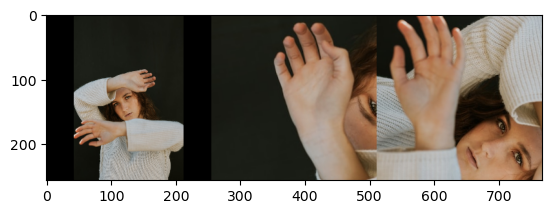

[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([2, 24, 64, 64])  channel_pad= 24
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([2, 48, 64, 64])
[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([2, 48, 32, 32])  channel_pad= 48
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([2, 96, 32, 32])
[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([2, 48, 32, 32])  channel_pad= 48
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([2, 96, 32, 32])
[BlazeBlock] BEFORE F.pad : x.shape= torch.Size([2, 96, 16, 16])  channel_pad= 192
[BlazeBlock] AFTER  F.pad : x.shape= torch.Size([2, 288, 16, 16])
[demo] flags2.shape= torch.Size([2])  flags2,= tensor([1.0000, 0.3290], grad_fn=<SigmoidBackward0>)
[demo] handed2.shape= torch.Size([2])  handed2,= tensor([0.6953, 0.1565], grad_fn=<SigmoidBackward0>)
[demo] normalized_landmarks2.shape= torch.Size([2, 21, 3])  normalized_landmarks2= tensor([[[ 6.5517e-01,  7.4587e-01,  3.3774e-05],
         [ 7.2736e-01,  5.4826e-01, -1.7882e-02],
         [ 7.4321e-01,  4

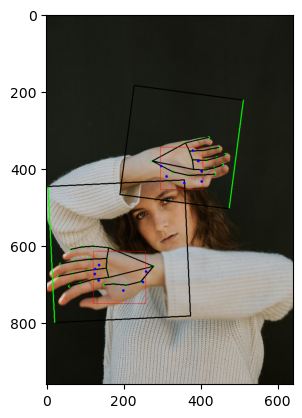

True

In [27]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

frame = cv2.imread(filename)
print("[demo] frame.shape=",frame.shape)
frame = np.ascontiguousarray(frame[:,:,::-1])
print("[demo] frame.shape=",frame.shape)
hh, ww, _ = frame.shape
ll = min(hh, ww)
#img = cv2.resize(frame[:ll, :ll][:, ::-1], (256, 256))
#img = cv2.resize(frame, (256, 256))
#print(img.shape)
#print(isinstance(img, np.ndarray))
img1, img2, scale, pad = resize_pad(frame)
print("[demo] img1.shape=",img1.shape," img1.dtype=",img1.dtype)
print("[demo] img2.shape=",img2.shape," img2.dtype=",img2.dtype)
print("[demo] scale=",scale)
print("[demo] pad=",pad)
normalized_palm_detections = model_palm.predict_on_image(img1)
print("[demo] normalized_palm_detections=",normalized_palm_detections)
palm_detections = denormalize_detections(normalized_palm_detections, scale, pad)
print("[demo] palm_detections=",palm_detections)

xc, yc, scale, theta = model_palm.detection2roi(palm_detections.cpu())
print("[demo] xc.shape,=",xc.shape," xc=",xc)
print("[demo] yc.shape,=",yc.shape," yc=",yc)
print("[demo] scale.shape,=",scale.shape," scale=",scale)
print("[demo] theta.shape,=",theta.shape," theta=",theta)
hand_img, affine2, box2 = model.extract_roi(frame, xc, yc, theta, scale)
print("[demo] hand_img.shape=",hand_img.shape," hand_img.dtype=",hand_img.dtype)
print("[demo] affine2.shape,=",affine2.shape," affine2=",affine2)
print("[demo] box2.shape=",box2.shape, " box2=",box2)

debug_img = img1.astype(np.float32)/255.0
for i in range(hand_img.shape[0]):
    hand_img_i = np.array(hand_img[i])
    #print("[demo] hand_img_i.shape=",hand_img_i.shape," hand_img_i.dtype=",hand_img_i.dtype)
    hand_img_i = np.transpose(hand_img_i,(1, 2, 0))
    #print("[demo] hand_img_i.shape=",hand_img_i.shape," hand_img_i.dtype=",hand_img_i.dtype)
    debug_img = cv2.hconcat([debug_img,hand_img_i])
print("[demo] debug_img.shape=",debug_img.shape," debug_img.dtype=",debug_img.dtype)
plt.imshow(debug_img)
plt.show()
#debug_img = (debug_image*255.0).astype(np.uint8)
#debug_img = cv2.cvtColor(debug_img,cv2.COLOR_RGB2BGR)
#cv2.imwrite('image_debug.png',debug_img)

flags2, handed2, normalized_landmarks2 = model(hand_img.to(device))
print("[demo] flags2.shape=",flags2.shape," flags2,=",flags2)
print("[demo] handed2.shape=",handed2.shape," handed2,=",handed2)
print("[demo] normalized_landmarks2.shape=",normalized_landmarks2.shape," normalized_landmarks2=",normalized_landmarks2)
landmarks2 = model.denormalize_landmarks(normalized_landmarks2.cpu(), affine2)
print("[demo] landmarks2.shape=",landmarks2.shape," landmarks2=",landmarks2)
    
for i in range(len(flags2)):
    landmark, flag = landmarks2[i], flags2[i]
    #print(flags2[i],handed2[i],landmarks2[i])
    #if flag>.5:
    if flag>.3:
        draw_landmarks(frame, landmark[:,:2], HAND_CONNECTIONS, size=2)

draw_roi(frame, box2)
draw_detections(frame, palm_detections)


plt.imshow(frame)
plt.show()
frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
cv2.imwrite('image_detection.png',frame)

----

Copyright (C) 2024 Avnet, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----